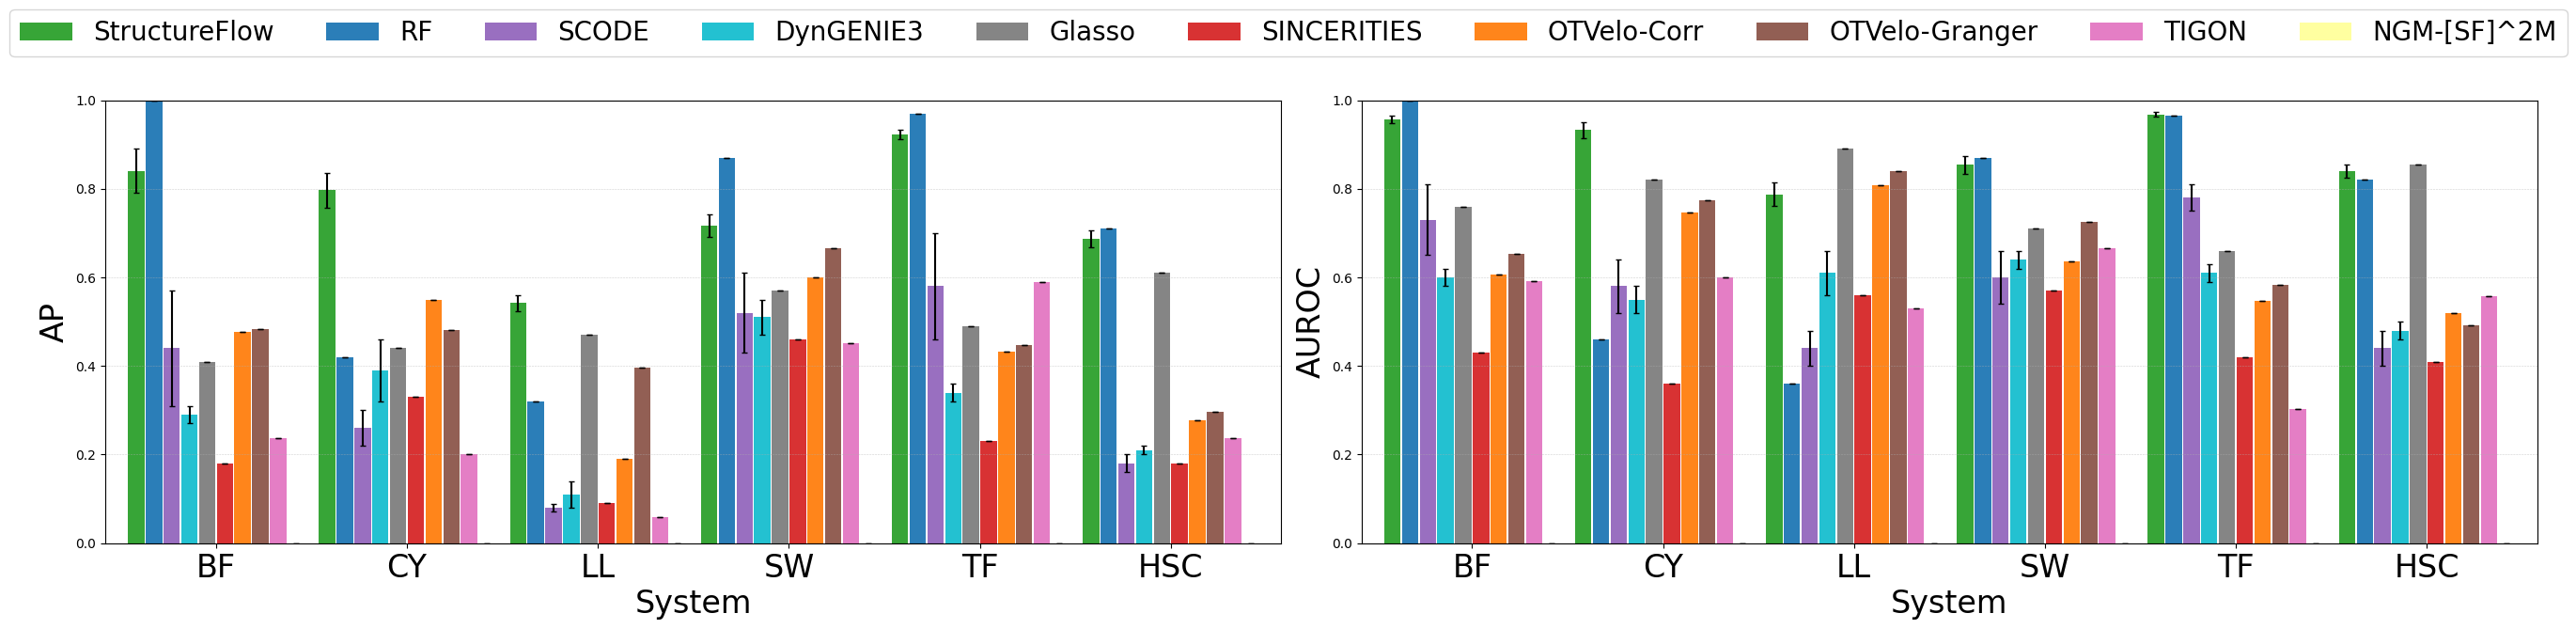

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load your CSV ---
csv_path = "../src/jobs/results1.csv"  # <-- change to your file path
df = pd.read_csv(csv_path)

# --- ordering & colors to match the figure ---
dataset_order = ["BF", "CY", "LL", "SW", "TF", "HSC"]
method_order  = ["StructureFlow", "RF", "SCODE", "DynGENIE3", "Glasso", "SINCERITIES","OTVelo-Corr", "OTVelo-Granger", "TIGON", "NGM-[SF]^2M"]
colors = {
    "StructureFlow": "#2ca02c",  # green
    "RF": "#1f77b4",             # blue
    "SCODE": "#9467bd",          # purple
    "DynGENIE3": "#17becf",      # teal/cyan
    "Glasso": "#7f7f7f",         # gray
    "SINCERITIES": "#d62728",    # red
    "OTVelo-Corr": "#ff7f0e",    # orange
    "OTVelo-Granger": "#8c564b",  # brown
    "TIGON": "#e377c2",          # pink
    "NGM-[SF]^2M": "#ffff9b"     # sun
}

BAR_WIDTH  = 0.12
INNER_GAP  = 0.01   # tiny gap between adjacent methods within a system
GROUP_GAP  = 0.10   # tiny gap between systems (datasets)

# --- pivot to [dataset x method] for means and stds ---
def make_pivots(df, mean_col, std_col):
    mean_p = (df.pivot(index="dataset", columns="method", values=mean_col)
                .reindex(index=dataset_order, columns=method_order))
    std_p  = (df.pivot(index="dataset", columns="method", values=std_col)
                .reindex(index=dataset_order, columns=method_order))
    return mean_p.fillna(0.0), std_p.fillna(0.0)

AP_mean, AP_std   = make_pivots(df, "AP_mean", "AP_std")
ROC_mean, ROC_std = make_pivots(df, "ROC_AUC_mean", "ROC_AUC_std")

# --- plotting helper (now scales x to fit groups cleanly) ---
def plot_grouped_bars(ax, mean_pivot, std_pivot, ylabel):
    m = len(mean_pivot.columns)
    d = len(mean_pivot.index)
    sep = BAR_WIDTH + INNER_GAP
    group_span = m * sep  # total span of bars (using centers) per dataset

    # space datasets far enough apart so groups don't overlap
    x = np.arange(d) * (group_span + GROUP_GAP)

    for i, method in enumerate(mean_pivot.columns):
        means = mean_pivot[method].values
        stds  = std_pivot[method].values
        pos = x + (i - (m - 1) / 2) * sep
        ax.bar(
            pos, means, BAR_WIDTH,
            label=method,
            yerr=stds, capsize=2,
            color=colors[method], linewidth=0.4, alpha=0.95
        )

    ax.set_xticks(x)
    ax.set_xticklabels(mean_pivot.index, fontsize=24)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.set_xlabel("System", fontsize=24)
    ax.grid(axis="y", linestyle="--", linewidth=0.4, alpha=0.6)
    ax.margins(x=0.02)

# --- dynamic figure width based on methods & datasets ---
m = len(method_order)
d = len(dataset_order)
sep = BAR_WIDTH + INNER_GAP
group_span = m * sep
# 3.2 is a good visual scaling factor for two subplots side-by-side; bump if needed
fig_w = max(18, 3.2 * d * (group_span + GROUP_GAP))

fig, axes = plt.subplots(1, 2, figsize=(fig_w, 6), sharey=False)

plot_grouped_bars(axes[0], AP_mean,  AP_std,  "AP")
plot_grouped_bars(axes[1], ROC_mean, ROC_std, "AUROC")

# legend across the top; wrap if it gets too wide by lowering ncol
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(method_order),
           loc="upper center", bbox_to_anchor=(0.5, 1.13), frameon=True, fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# optional: save to file
fig.savefig("ap_auroc_barplot.pdf", dpi=300, bbox_inches="tight")


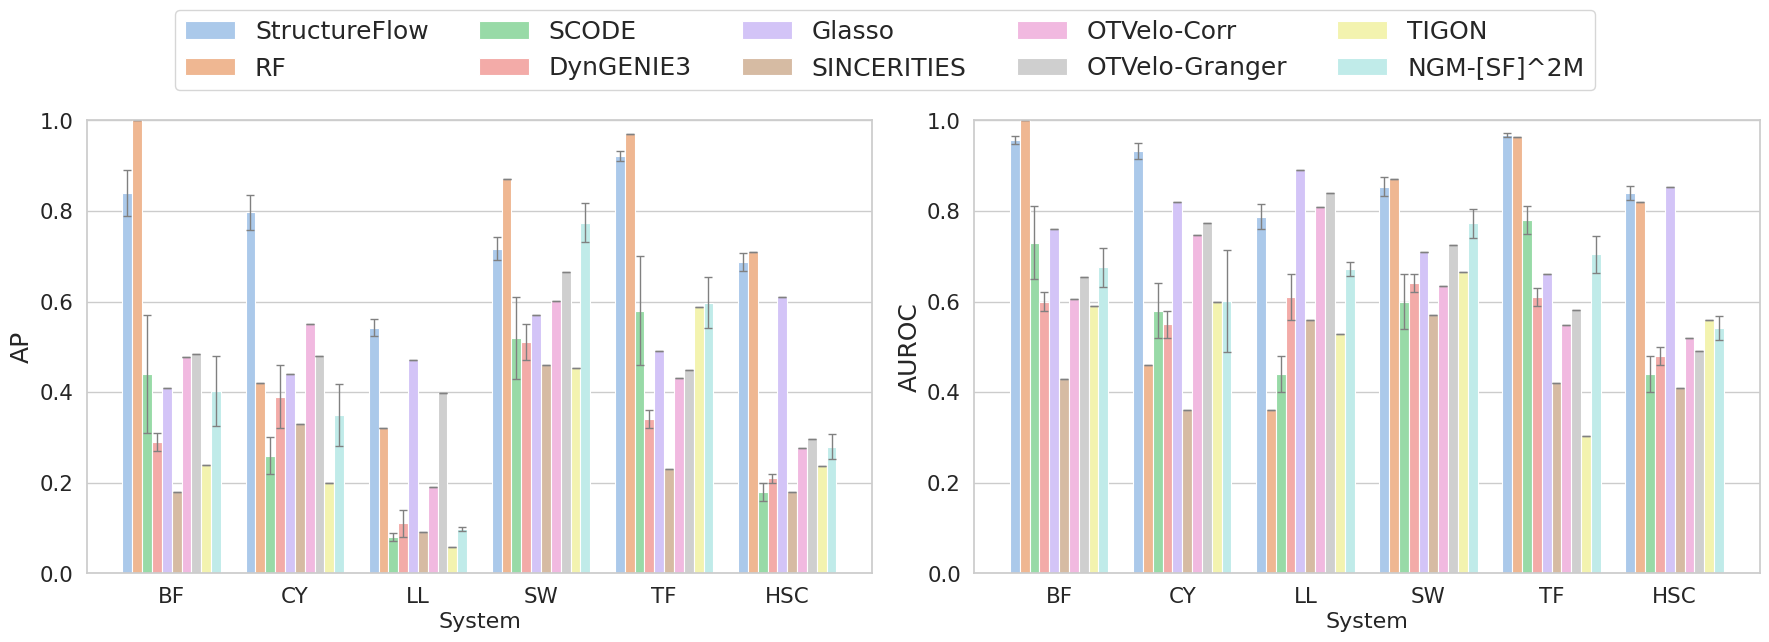

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- load your CSV ---
csv_path = "../src/jobs/results1.csv"  # <-- change to your file path
df = pd.read_csv(csv_path)

# --- enforce ordering ---
dataset_order = ["BF", "CY", "LL", "SW", "TF", "HSC"]
method_order  = ["StructureFlow", "RF", "SCODE", "DynGENIE3", "Glasso", "SINCERITIES",
                 "OTVelo-Corr", "OTVelo-Granger", "TIGON", "NGM-[SF]^2M"]

# keep only needed columns
df = df[df["dataset"].isin(dataset_order) & df["method"].isin(method_order)]

df_ap = df.melt(
    id_vars=["dataset", "method"],
    value_vars=["AP_mean", "ROC_AUC_mean"],
    var_name="metric",
    value_name="score"
)

metric_map = {"AP_mean": "AP", "ROC_AUC_mean": "AUROC"}
df_ap["metric"] = df_ap["metric"].map(metric_map)

df_std = df.melt(
    id_vars=["dataset", "method"],
    value_vars=["AP_std", "ROC_AUC_std"],
    var_name="metric",
    value_name="std"
)
std_map = {"AP_std": "AP", "ROC_AUC_std": "AUROC"}
df_std["metric"] = df_std["metric"].map(std_map)

# --- set style ---
sns.set_theme(style="whitegrid", font_scale=1.4)

# --- plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

df_long = pd.merge(
    df_ap, df_std,
    on=["dataset", "method", "metric"],
    how="inner"
)

for ax, metric in zip(axes, ["AP", "AUROC"]):
    sub = df_long[df_long["metric"] == metric]
    sns.barplot(
        data=sub,
        x="dataset", y="score", hue="method",
        order=dataset_order,
        hue_order=method_order,
        palette="pastel",   
        ax=ax,
        errorbar=None,
        dodge=True,
        linewidth=0.8, 
    )

    bar_group_width = 0.8               
    n_hue = len(method_order)
    bar_width = bar_group_width / n_hue
    offsets = np.linspace(-bar_group_width/2 + bar_width/2,
                        bar_group_width/2 - bar_width/2,
                        n_hue)

    for di, dataset in enumerate(dataset_order):
        for mi, method in enumerate(method_order):
            row = sub[(sub["dataset"] == dataset) & (sub["method"] == method)]
            if row.empty:
                continue
            x = di + offsets[mi]
            y = float(row["score"].iloc[0])
            yerr = float(row["std"].iloc[0])
            ax.errorbar(x, y, yerr=yerr, fmt="none",
                        ecolor="gray", elinewidth=1.0, capsize=3)

    ax.set_xlabel("System", fontsize=16)
    ax.set_ylabel(metric, fontsize=18)
    ax.set_ylim(0, 1.0)

    ax.legend_.remove()
# legend across top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,
           loc="upper center", bbox_to_anchor=(0.5, 1.1),
           frameon=True, fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# optional: save
fig.savefig("ap_auroc_barplot_seaborn.pdf", dpi=300, bbox_inches="tight")


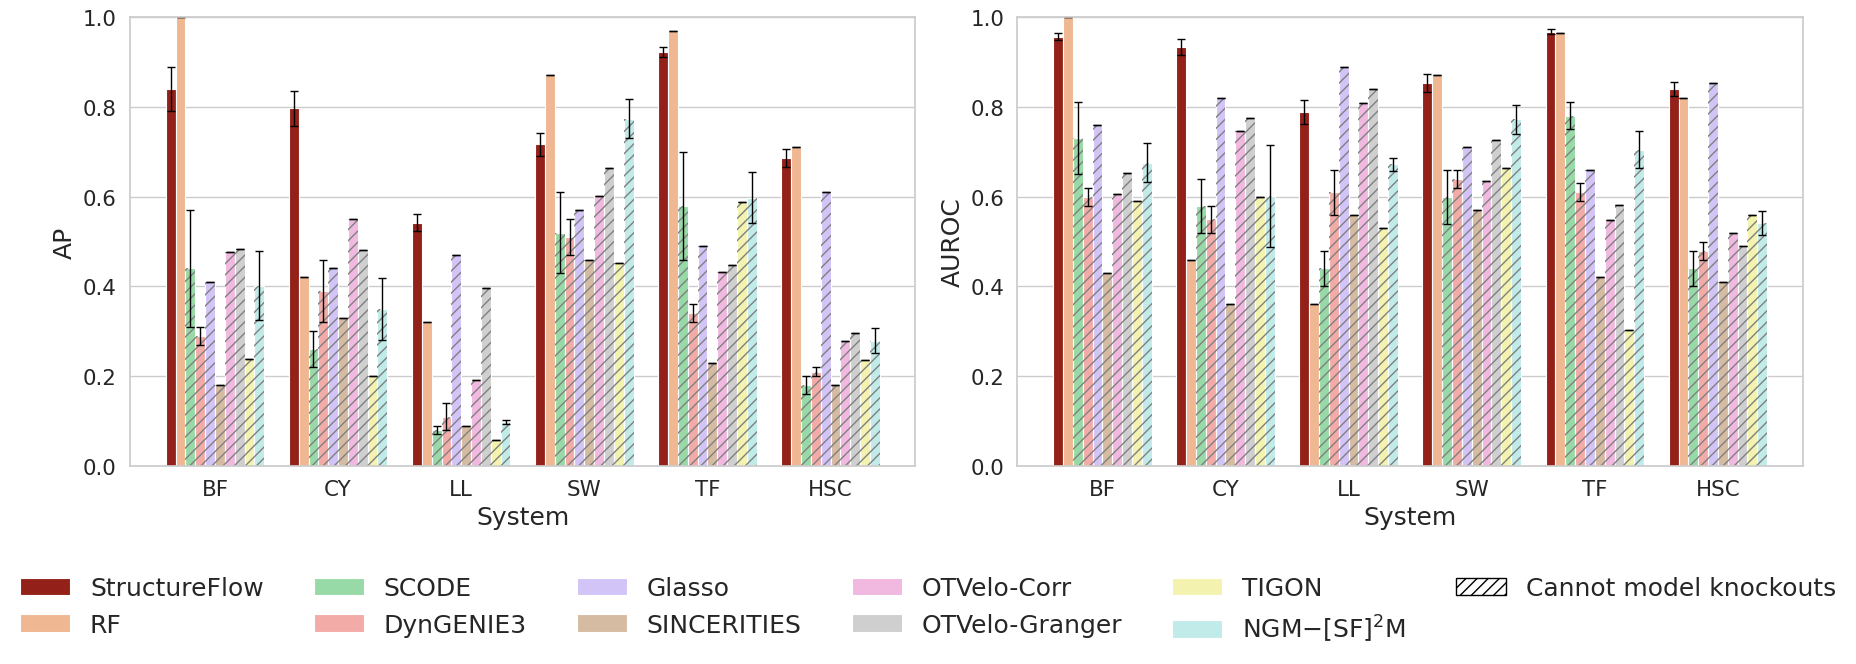

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch, Rectangle

# --- load your CSV ---
csv_path = "../src/jobs/results1.csv"  # <-- change to your file path
df = pd.read_csv(csv_path)

# --- enforce ordering ---
dataset_order = ["BF", "CY", "LL", "SW", "TF", "HSC"]
method_order  = ["StructureFlow", "RF", "SCODE", "DynGENIE3", "Glasso", "SINCERITIES",
                 "OTVelo-Corr", "OTVelo-Granger", "TIGON", r"$\mathrm{NGM{-}[SF]^{2}M}$"]

df = df[df["dataset"].isin(dataset_order) & df["method"].isin(method_order)]

df_ap = df.melt(
    id_vars=["dataset", "method"],
    value_vars=["AP_mean", "ROC_AUC_mean"],
    var_name="metric",
    value_name="score"
)

metric_map = {"AP_mean": "AP", "ROC_AUC_mean": "AUROC"}
df_ap["metric"] = df_ap["metric"].map(metric_map)

df_std = df.melt(
    id_vars=["dataset", "method"],
    value_vars=["AP_std", "ROC_AUC_std"],
    var_name="metric",
    value_name="std"
)
std_map = {"AP_std": "AP", "ROC_AUC_std": "AUROC"}
df_std["metric"] = df_std["metric"].map(std_map)

sns.set_theme(style="whitegrid", font_scale=1.4)

base_colors = sns.color_palette("pastel", n_colors=len(method_order))
palette = {m: c for m, c in zip(method_order, base_colors)}
palette["StructureFlow"] = "#a7100595"  # darker green highlight

# --- plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

df_long = pd.merge(
    df_ap, df_std,
    on=["dataset", "method", "metric"],
    how="inner"
)

for ax, metric in zip(axes, ["AP", "AUROC"]):
    sub = df_long[df_long["metric"] == metric]
    sns.barplot(
        data=sub,
        x="dataset", y="score", hue="method",
        order=dataset_order,
        hue_order=method_order,
        palette=palette,   
        ax=ax,
        errorbar=None,
        dodge=True,
        linewidth=0.8, 
    )

    bar_group_width = 0.8               
    n_hue = len(method_order)
    bar_width = bar_group_width / n_hue
    offsets = np.linspace(-bar_group_width/2 + bar_width/2,
                        bar_group_width/2 - bar_width/2,
                        n_hue)

    for di, dataset in enumerate(dataset_order):
        for mi, method in enumerate(method_order):
            row = sub[(sub["dataset"] == dataset) & (sub["method"] == method)]
            if row.empty:
                continue
            x = di + offsets[mi]
            y = float(row["score"].iloc[0])
            yerr = float(row["std"].iloc[0])
            ax.errorbar(x, y, yerr=yerr, fmt="none",
                        ecolor="black", elinewidth=1.0, capsize=3)

            if method not in {"StructureFlow", "RF"}:
                rect = Rectangle((x - bar_width/2, 0), bar_width, y,
                                 facecolor='none', edgecolor='gray',
                                 hatch='///', linewidth=0.0)
                ax.add_patch(rect)

    ax.set_xlabel("System", fontsize=18)
    ax.set_ylabel(metric, fontsize=18)
    ax.set_ylim(0, 1.0)

    ax.legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()

hatch_proxy = Patch(facecolor='white', edgecolor='black', hatch='///', label='Cannot model knockouts')
handles = list(handles) + [hatch_proxy]
labels  = list(labels)  + ['Cannot model knockouts']

fig.legend(handles, labels, ncol=6,
           loc="upper center", bbox_to_anchor=(0.5, -0.0001),
           frameon=False, fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("ap_auroc_barplot_seaborn.pdf", dpi=300, bbox_inches="tight")


/tmp/ipykernel_1712680/1789063605.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1712680/1789063605.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1712680/1789063605.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1712680/1789063605.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


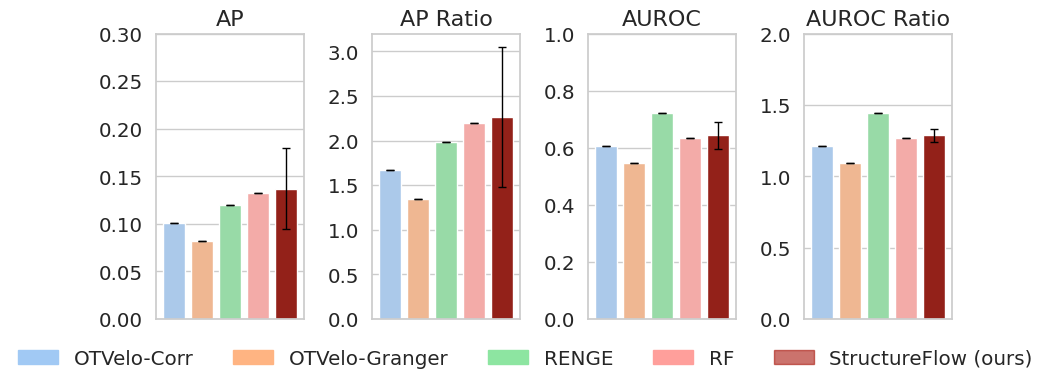

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "scores.csv"
df = pd.read_csv(csv_path)

# keep the 4 methods in the order you want
method_order = ["OTVelo-Corr", "OTVelo-Granger", "RENGE", "RF", "StructureFlow (ours)"]
df = df[df["method"].isin(method_order)].copy()

# ------------------ compute ratios ------------------
df["AUROC_ratio_mean"] = df["AUROC_mean"] / 0.5
df["AUROC_ratio_std"]  = df["AUROC_std"]

# AP ratio = AP / AP_random  (AP_random is class prevalence)
if "AP_random" not in df.columns:
    df["AP_random"] = 0.06050605060506051
df["AP_ratio_mean"] = df["AP_mean"] / df["AP_random"]
df["AP_ratio_std"]  = df["AP_ratio_std"]

# ------------------ reshape for plotting ------------------
value_cols = {
    "AP": "AP_mean",
    "AP Ratio": "AP_ratio_mean",
    "AUROC": "AUROC_mean",
    "AUROC Ratio": "AUROC_ratio_mean",
}
std_cols = {
    "AP": "AP_std",
    "AP Ratio": "AP_ratio_std",
    "AUROC": "AUROC_std",
    "AUROC Ratio": "AUROC_ratio_std",
}

base_colors = sns.color_palette("pastel", n_colors=len(method_order))
palette = {m: c for m, c in zip(method_order, base_colors)}
palette["StructureFlow (ours)"] = "#a7100595"  # darker green highlight

rows = []
for metric, vcol in value_cols.items():
    if vcol not in df.columns:
        continue
    for _, r in df.iterrows():
        rows.append({
            "method": r["method"],
            "metric": metric,
            "score": r[vcol],
            "std":   r.get(std_cols[metric], np.nan)
        })
plot_df = pd.DataFrame(rows)

# ------------------ styling ------------------
sns.set_theme(style="whitegrid", font_scale=1.3)

# y-limits to match your figure vibe
ylims = {"AP": (0, 0.3), "AP Ratio": (0, 3.2), "AUROC": (0.0, 1.0), "AUROC Ratio": (0, 2.0)}

# ------------------ plot ------------------
fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharey=False)

for ax, metric in zip(axes, ["AP", "AP Ratio", "AUROC", "AUROC Ratio"]):
    sub = plot_df[plot_df["metric"] == metric]
    # bars
    sns.barplot(
        data=sub, x="method", y="score",
        order=method_order, palette=palette,
        errorbar=None, ax=ax
    )
    # error bars
    for i, m in enumerate(method_order):
        row = sub[sub["method"] == m]
        if row.empty: continue
        ax.errorbar(i, row["score"].iloc[0], yerr=row["std"].iloc[0],
                    fmt="none", ecolor="black", elinewidth=1, capsize=3)

    ax.set_title(metric, fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if metric in ylims: ax.set_ylim(*ylims[metric])

    # --- remove model names from the x-axis ---
    ax.set_xticklabels([])
    ax.tick_params(axis='x', length=0)

# legend at the bottom
handles = [plt.Rectangle((0,0),1,1,color=palette[m]) for m in method_order]
fig.legend(handles, method_order, ncol=5, loc="lower center",
           bbox_to_anchor=(0.5, 0.0), frameon=False)

# leave room at the bottom for the legend
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

fig.savefig("four_panel_metrics.pdf", dpi=300, bbox_inches="tight")
